# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from scipy.optimize import fmin
import torch

from indentation.indentationset import IndentationSet
from indentation.processing.find_contact import findContact_minimum, findContact_blackMagic, findContact_blackMagic_CNN
from indentation.processing.signal import do_nothing
from indentation.processing.calculate_parameters import parameter_youngs_modulus
from indentation.processing.plotting import plot_curve_parameters_bar, plot_instance_parameters_bar, plot_mean_force_curves
from indentation.ml.models import ConvClassifier_1, ConvClassifier_2

# Use Case 1: Load all Files and Process them Together

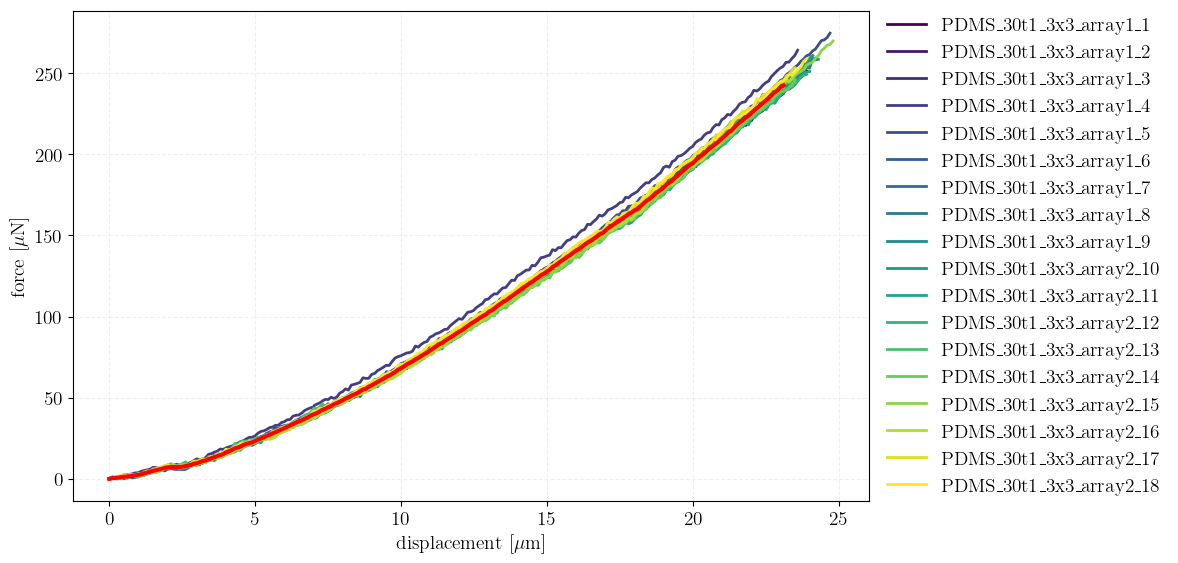

In [4]:
experiment_paths = [r"example_data/PDMS_30t1_3x3_array1.dat", r"example_data/PDMS_30t1_3x3_array2.dat"]

indentation_set = IndentationSet(experiment_paths, exp_type='ft')

# Define processing pipeline: chain processing functions after eachother. 
# Be aware that some require others to run first to work. check/extend processing.py
processing_pipeline = [do_nothing, 
                       findContact_minimum]

# Process all curves in the measurement set
indentation_set.process_raw(processing_pipeline)
indentation_set.calculate_mean()

fig, ax = plt.subplots(figsize=(12, 6))  # Create a new figure and axis
indentation_set.plot("all", ax=ax, show_title=False, show=False)  # Plot on `ax` without showing
ax.plot(-indentation_set.mean["z"], indentation_set.mean["force"], "r", lw=3)  # Add the second line on `ax`
plt.show()  # Display both lines together

## Calculate Parameter for each Curve: Example - Youngs Modulus

Mean and std: 122.93775923052047 2.4169490879826263


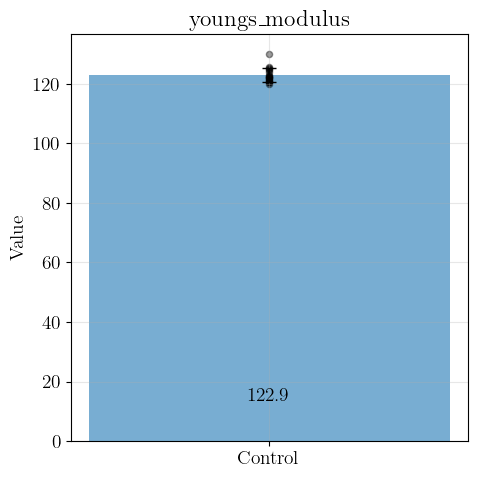

In [11]:
function_arguments = dict(radius=100, nu=0.5, cutoff=20, keyname="youngs_modulus")
indentation_set.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)
plot_curve_parameters_bar(indentation_set,
                         parameter_names=['youngs_modulus'],
                         labels=['Control'],
                         figsize=(5,5))

## Vary a Parameter within an Instance: Example Cutoff

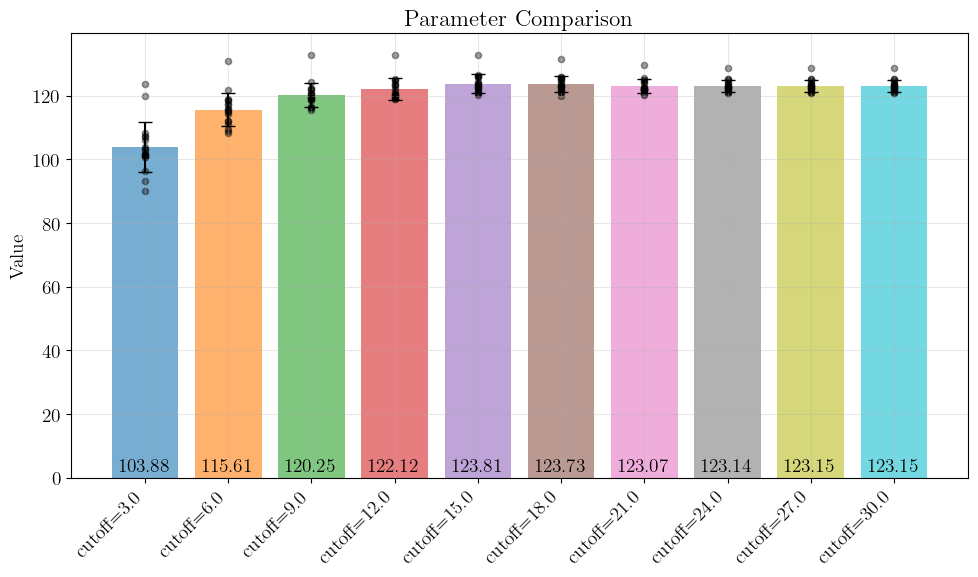

In [12]:
cutoffs = np.linspace(3, 30, 10)

for cutoff in cutoffs:
    function_arguments = dict(radius=100, nu=0.5, cutoff=cutoff, keyname="cutoff="+str(cutoff))
    indentation_set.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)

plot_instance_parameters_bar(indentation_set,
                         parameter_names=[*["cutoff="+str(cutoff) for cutoff in cutoffs]],
                         labels=[*["cutoff="+str(cutoff) for cutoff in cutoffs]],
                         figsize=(10,6))

# Use Case 2: Load all Files Separately and Process them Apart

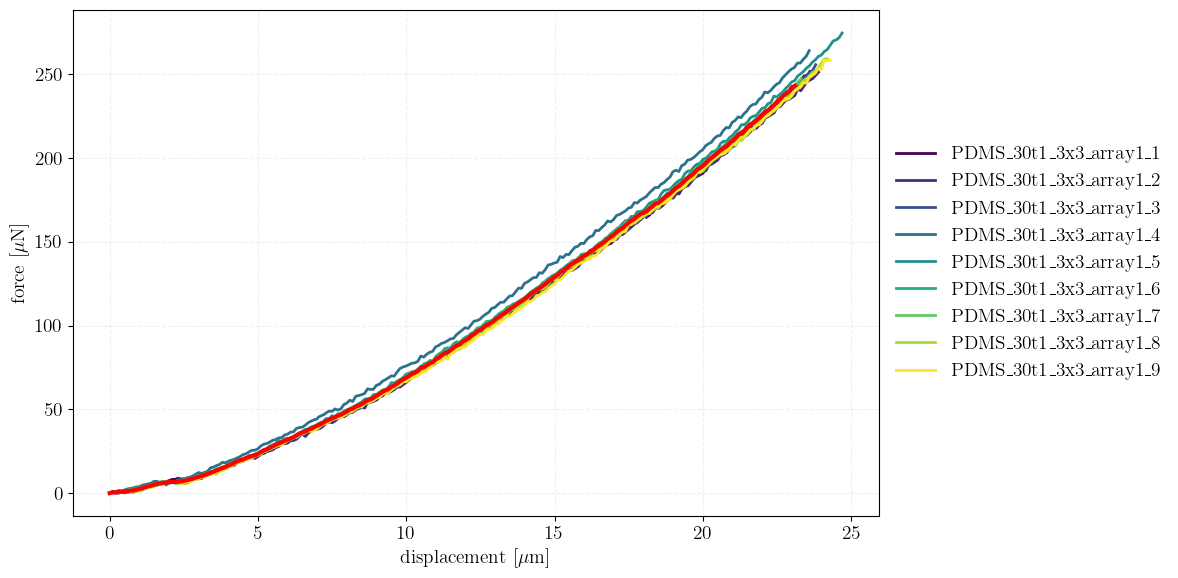

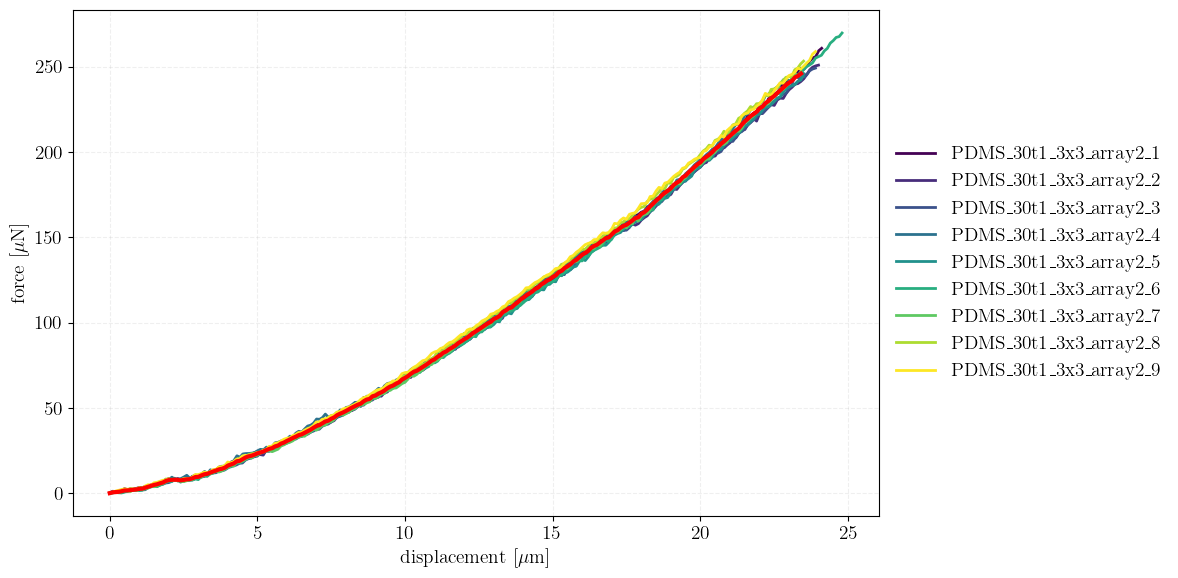

In [13]:
experiment_path = [r"example_data/PDMS_30t1_3x3_array1.dat", r"example_data/PDMS_30t1_3x3_array2.dat"]

indentation_sets = [IndentationSet(path, exp_type='ft') for path in experiment_path]

# Define processing pipeline: chain processing functions after eachother. 
# Be aware that some require others to run first to work. check/extend processing.py

function_arguments = dict(radius=100, nu=0.5, cutoff=20)

for ids in indentation_sets:        
    processing_pipeline = [do_nothing, 
                           findContact_minimum]
    
    # Process all curves in the measurement set
    ids.process_raw(processing_pipeline)
    ids.calculate_mean()
    ids.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)
    
    fig, ax = plt.subplots(figsize=(12, 6))  # Create a new figure and axis
    ids.plot("all", ax=ax, show_title=False, show=False)  # Plot on `ax` without showing
    ax.plot(-ids.mean["z"], ids.mean["force"], "r", lw=3)  # Add the second line on `ax`
    plt.show()  # Display both lines together

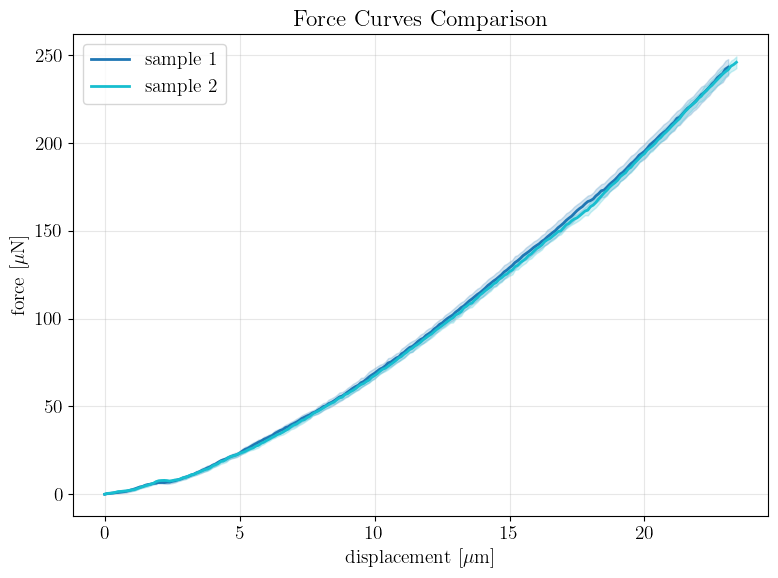

In [14]:
plot_mean_force_curves(*indentation_sets,
                         parameter_names=['youngs_modulus'],
                         labels=['sample 1', 'sample 2'])

## Compare a Parameter Across IndentationSets

Mean and std: 123.84574123931831 2.6284730050546923
Mean and std: 122.02977722172267 1.7679232994951495


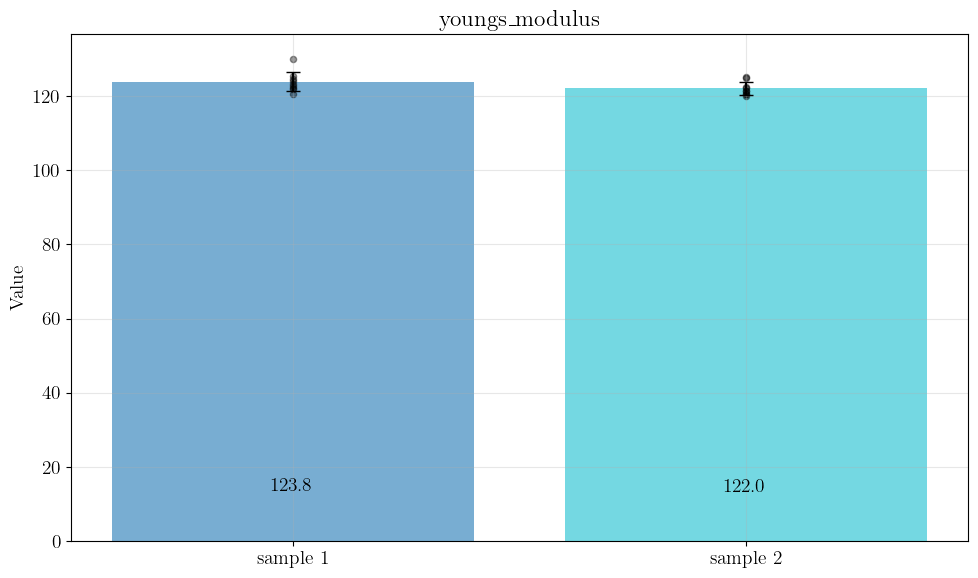

In [15]:
plot_curve_parameters_bar(*indentation_sets,
                         parameter_names=['youngs_modulus'],
                         labels=['sample 1', 'sample 2'])

# Other Contact Finding Functions

In [16]:
# load neural net parameters
model_path = "indentation/ml/immersed_model.pth"

N=100
net = ConvClassifier_2(N)

net.load_state_dict(torch.load(model_path, weights_only=True))
net.eval()  # Set to evaluation mode if you are not training

ConvClassifier_2(
  (conv1x1): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv3x3): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5x5): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv13x13): Conv2d(1, 16, kernel_size=(13, 13), stride=(1, 1), padding=(6, 6))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=73728, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
experiment_paths = [r"example_data/PDMS_30t1_3x3_array1.dat", r"example_data/PDMS_30t1_3x3_array2.dat"]

indentation_set1 = IndentationSet(experiment_paths, exp_type='ft')
indentation_set2 = IndentationSet(experiment_paths, exp_type='ft')
indentation_set3 = IndentationSet(experiment_paths, exp_type='ft')

# Define processing pipeline: chain processing functions after eachother. 
# Be aware that some require others to run first to work. check/extend processing.py
processing_pipeline1 = [findContact_minimum]
processing_pipeline2 = [partial(findContact_blackMagic, N_int=1000, padding_fraction=0.02)]
processing_pipeline3 = [partial(findContact_blackMagic_CNN, net=net, N=100)]

# Process all curves in the measurement set
indentation_set1.process_raw(processing_pipeline1)
indentation_set2.process_raw(processing_pipeline2)
indentation_set3.process_raw(processing_pipeline3)

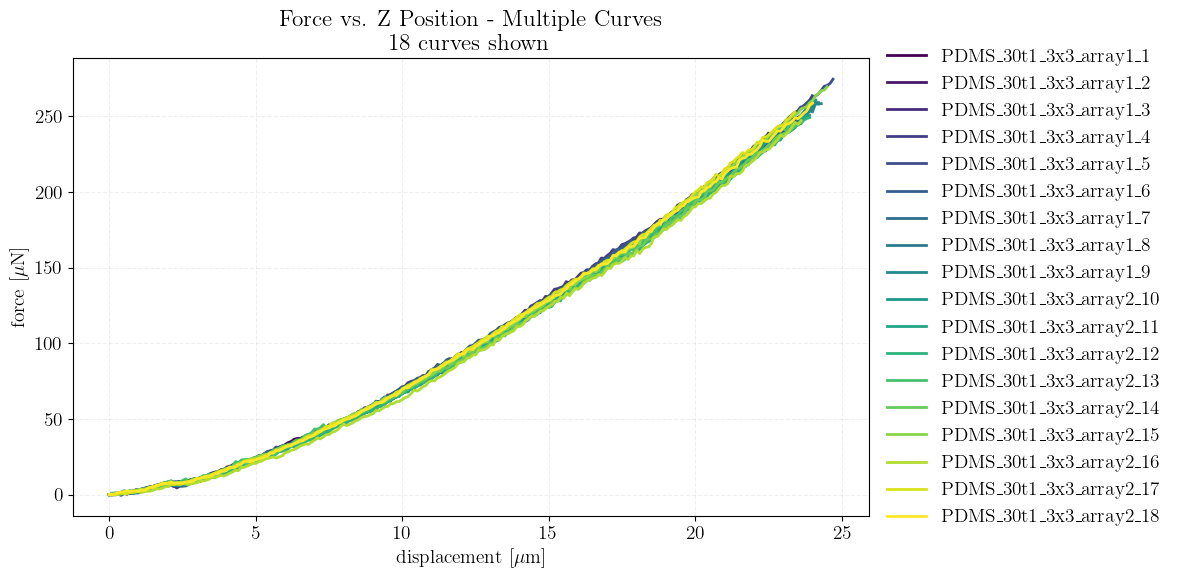

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Force vs. Z Position - Multiple Curves\n18 curves shown'}, xlabel='displacement [$\\mu$m]', ylabel='force [$\\mu$N]'>)

In [19]:
indentation_set2.plot("all")

Mean and std: 122.93775923052047 2.4169490879826263
Mean and std: 123.32388768258963 1.8006783072365087
Mean and std: 125.25184567420668 1.8289586585226718


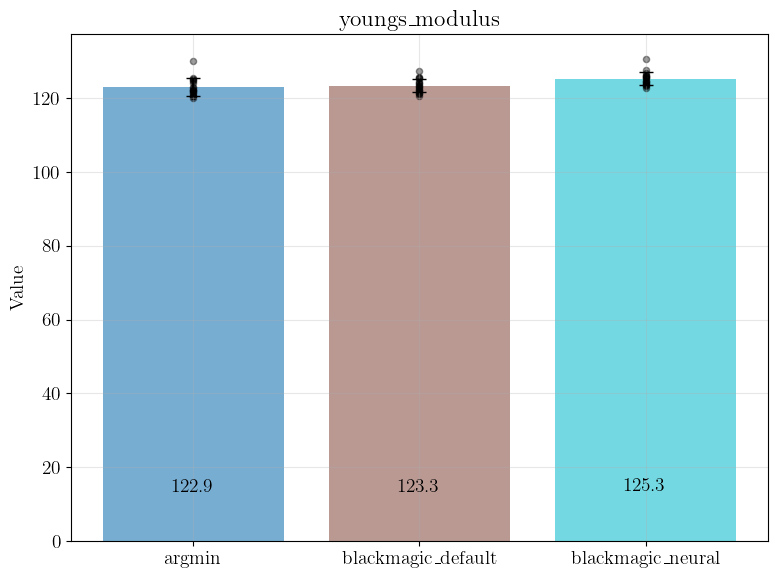

In [20]:
function_arguments = dict(radius=100, nu=0.5, cutoff=20, keyname="youngs_modulus")
indentation_set1.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)
indentation_set2.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)
indentation_set3.calculate_curve_parameter(function=parameter_youngs_modulus, **function_arguments)

plot_curve_parameters_bar(indentation_set1, indentation_set2, indentation_set3,
                         parameter_names=['youngs_modulus'],
                         labels=['argmin', 'blackmagic_default', 'blackmagic_neural'],
                         figsize=(8,6))

# Sandbox

In [21]:
from indentation.utils.math import numdiff
import cv2

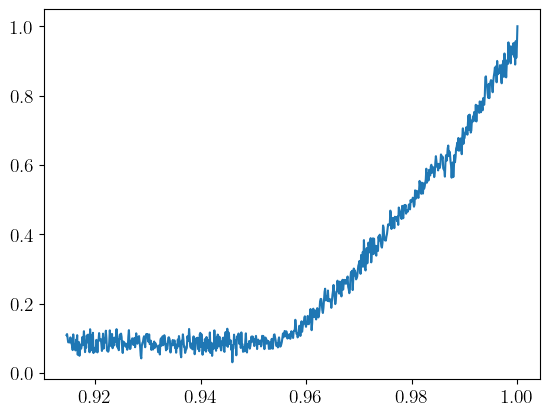

In [22]:
experiment_paths = [r"example_data/data_evelyn/20241021_PDMS_75t1_PG_4_G_3"]
indentation_set1 = IndentationSet(experiment_paths, exp_type="ft")
processing_pipeline1 = [partial(findContact_blackMagic, N_int=1000, padding_fraction=0.02)]
indentation_set1.process_raw(processing_pipeline1)

N_int = 800+3
k = 1
force_r = indentation_set1.data[k]["raw"]["force"]
displ_r = -indentation_set1.data[k]["raw"]["z"]

# interpolate data and normalize
displ = np.linspace(displ_r[0], displ_r[-1], N_int)
force = np.interp(displ, displ_r, force_r)

displ = displ/displ[-1]
force = force/force[-1]

plt.plot(displ, force)

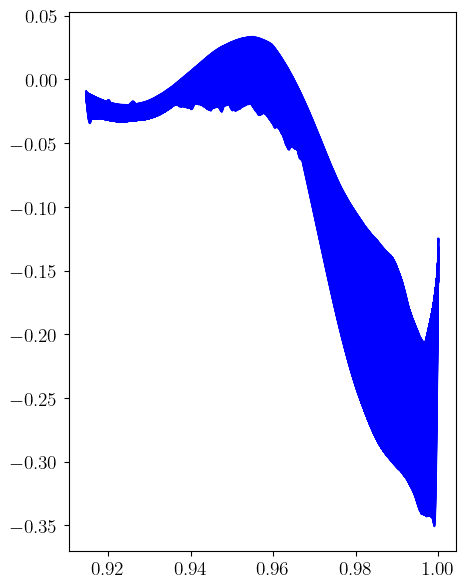

In [23]:
# window to use
padding = int(0.05*N_int)

# figure object and axes
plt.figure(figsize=(11, 7))
plt.subplot(121)

img = []
for n in range(padding, N_int-padding):
    # set up correct length for selected sigma

    # gaussian filter 
    xf = np.linspace(-2, 2, n)
    g  = 1/(np.sqrt(2*np.pi))*np.exp(-xf**2/(2.0))

    # normalize filter to interval
    g  = g/np.sum(g)

    # derivatives and the corresponding normalization
    dn  = 2
    _, ddg = numdiff(xf, g, dn)

    # convolve with mask
    yf  = np.convolve(force, ddg, mode='same')
    img.append(yf)
    plt.plot(displ, yf, 'b', lw=1.0)

img = np.array(img)

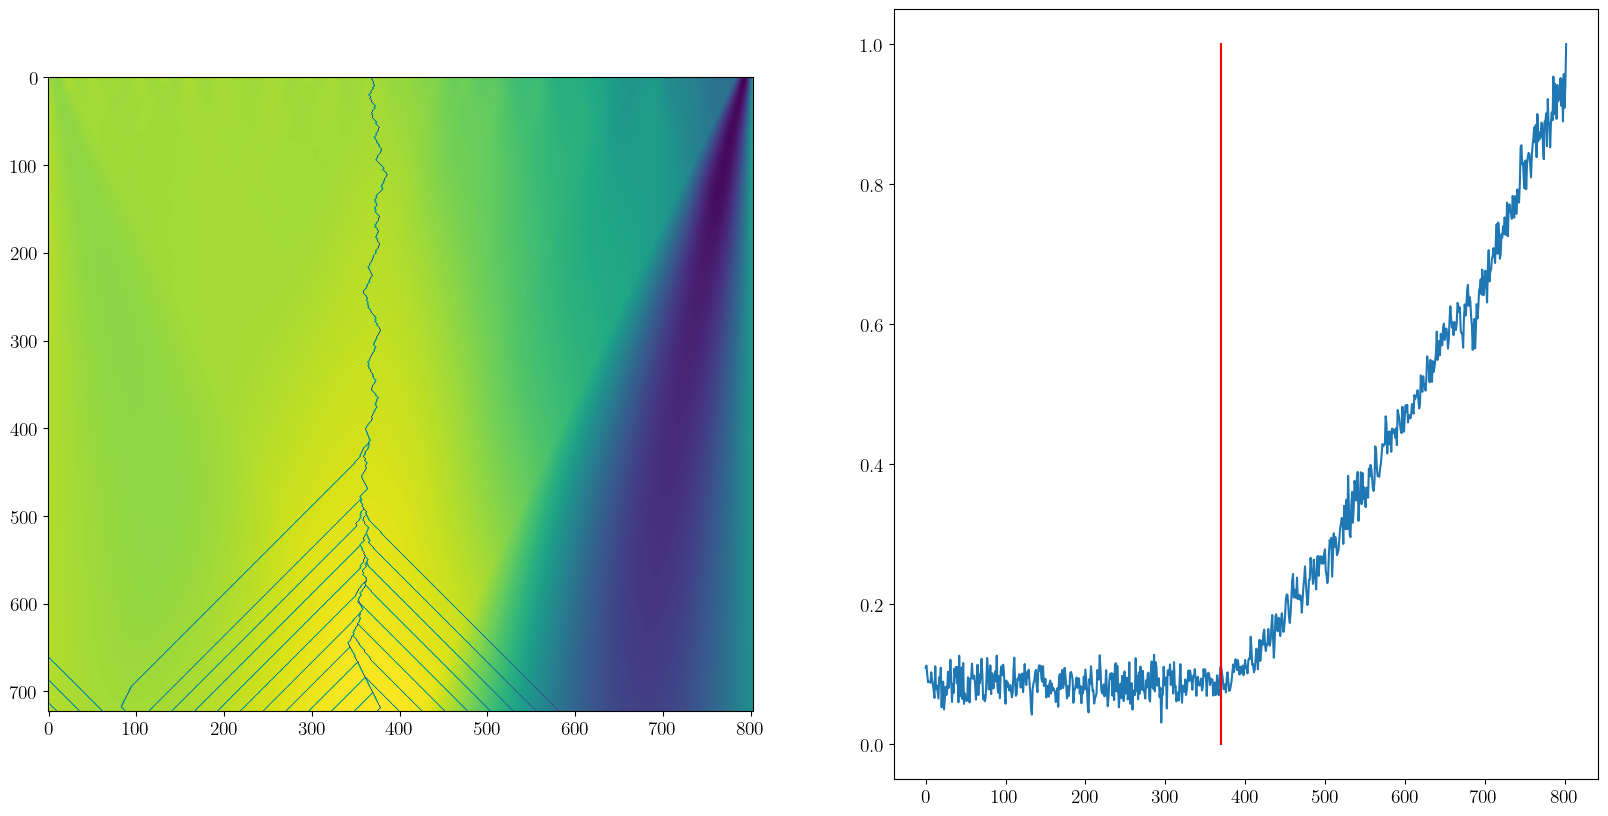

In [80]:
list_ix = []

imgc = img.copy()

zline = np.zeros((len(img.T)))

for ix_glob in range(10, int(3*N_int/4), int(N_int/30)):

    ix = ix_glob
    for i, line in enumerate(img[::-1]):
        ixs = [ix, ix+1, ix-1]
        ixmax = np.argmax([line[ixs[0]], line[ixs[1]], line[ixs[2]]])
        ix = ixs[ixmax]
        imgc[::-1][i, ix] = -0.3
        
    zline[ix] += 1
    list_ix.append(ix)
    
ix = np.argmax(zline)
ix

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(imgc)
plt.subplot(122)
plt.plot(force)
plt.plot([ix, ix], [0, 1], "r")
#plt.plot([exac_loc, exac_loc], [0, 1], "g")

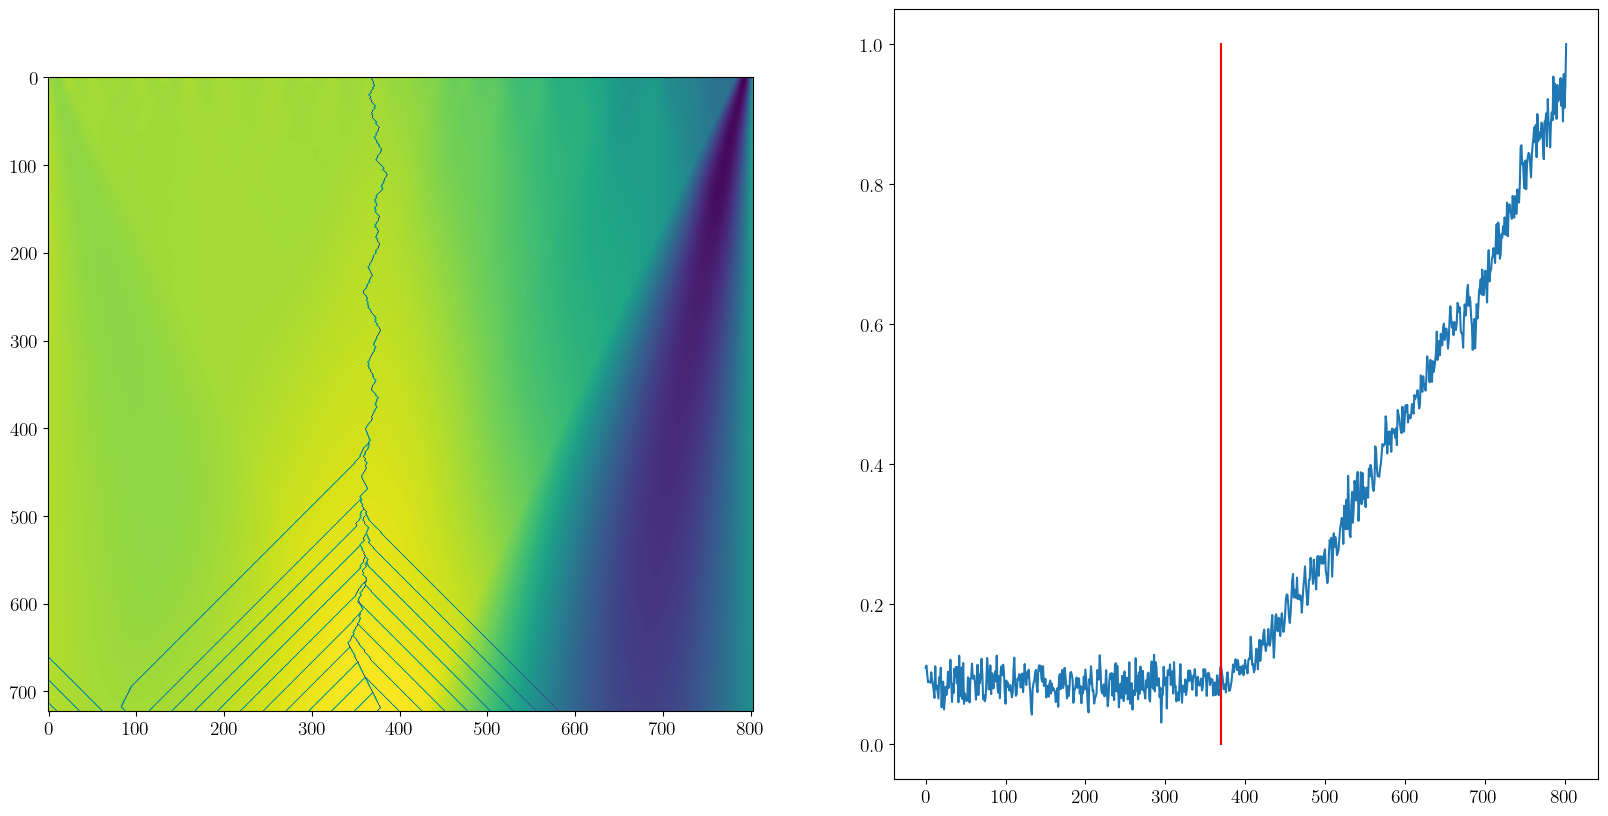

In [80]:
list_ix = []

imgc = img.copy()

zline = np.zeros((len(img.T)))

for ix_glob in range(10, int(3*N_int/4), int(N_int/30)):

    ix = ix_glob
    for i, line in enumerate(img[::-1]):
        ixs = [ix, ix+1, ix-1]
        ixmax = np.argmax([line[ixs[0]], line[ixs[1]], line[ixs[2]]])
        ix = ixs[ixmax]
        imgc[::-1][i, ix] = -0.3
        
    zline[ix] += 1
    list_ix.append(ix)
    
ix = np.argmax(zline)
ix

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(imgc)
plt.subplot(122)
plt.plot(force)
plt.plot([ix, ix], [0, 1], "r")
#plt.plot([exac_loc, exac_loc], [0, 1], "g")

In [81]:
imgn = img - img.min()
imgn = np.array(imgn/imgn.max()*2**16, dtype=np.uint16)

#cv2.imwrite("relief.png", imgn)